## Enhanced Agentic PageRAG with Elegant Schema Architecture

#### Real-World Applications:
1. **Financial Analysis**: SEC filings (10-K, 10-Q) with automatic company/year/section detection
2. **Legal Research**: Contracts and case law with jurisdiction/date/clause filtering  
3. **Medical Records**: Patient documents with date/provider/department filters
4. **Enterprise Docs**: Multi-project knowledge base with org/dept/category filters
5. **Research Papers**: Academic search with author/year/topic/section filters

In [ ]:
# ollama pull qwen3
# ollama pull qwen3:0.6b
# ollama pull nomic-embed-text


In [1]:
from typing_extensions import TypedDict, Annotated
from typing import Any, Dict
import operator
import os

from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from langchain_ollama import ChatOllama, OllamaEmbeddings
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_chroma import Chroma
from langchain_core.tools import tool
from IPython.display import display, Markdown

from scripts.schemas import ChunkMetadata
from scripts import utils

[DB] Total documents in database: 1270


In [2]:
# =============================================================================
# Configuration
# =============================================================================

LLM_MODEL = "qwen3"
BASE_URL = "http://localhost:11434"

llm = ChatOllama(
        model=LLM_MODEL,
        base_url=BASE_URL
    )

In [3]:
# =============================================================================
# State Definition
# =============================================================================

class AgenticRAGState(TypedDict):
    """State for agentic RAG workflow."""
    messages: Annotated[list, operator.add]

In [4]:
# =============================================================================
# Retriever Tool
# =============================================================================

@tool
def retrieve_docs(query: str, k=5) -> str:
    """
    Retrieve relevant financial documents from ChromaDB.
    Extracts filters from query and retrieves matching documents.

    Args:
        query: The search query (e.g., "What was Amazon's revenue in Q2 2025?")
        k: Number of documents to retrieve

    Returns:
        Retrieved documents with metadata as formatted string
    """
    print(f"\n[TOOL] retrieve_docs called")
    print(f"[QUERY] {query}")

    # Extract filters from query
    filters = utils.extract_filters(query)
    ranking_keywords = utils.generate_ranking_keywords(query)

    results = utils.search_docs(query, filters, ranking_keywords, k=20)

    docs = utils.rank_documents_by_keywords(results, ranking_keywords, k=k)

    print(f"[RETRIEVED] {len(docs)} documents")

    # Handle empty results
    if len(docs) == 0:
        return "No documents found. Try rephrasing your query or using different filters."

    # Format results
    retrieved_text = []

    for i, doc in enumerate(docs, 1):
        doc_text = [f"\n--- Document {i} ---"]

        # Add all metadata
        for key, value in doc.metadata.items():
            doc_text.append(f"{key}: {value}")

        # Add content
        doc_text.append(f"\nContent:\n{doc.page_content}")

        retrieved_text.append("\n".join(doc_text))

    retrieved_text = "\n".join(retrieved_text)

    # store retrieved text for debugging
    os.makedirs("debug_logs", exist_ok=True)
    with open("debug_logs/retrieved_reranked_docs.md", "w", encoding="utf-8") as f:
        f.write(retrieved_text)

    return retrieved_text

In [ ]:
# =============================================================================
# Agent Node
# =============================================================================

def agent_node(state: AgenticRAGState) -> dict:
    """Agent that decides when to use retriever tool."""
    messages = state["messages"]
    
    # Bind tool to LLM
    llm_with_tools = llm.bind_tools([retrieve_docs])
    
    # Detailed system message with step-by-step instructions
    system_msg = SystemMessage(
        content="""You are a financial document analysis assistant with access to a document retrieval tool.

                CRITICAL RULES:
                1. ALWAYS use the retrieve_docs tool first - NEVER answer from memory
                2. You MUST call the tool before providing any financial information
                3. Answer ONLY based on the retrieved documents
                4. If documents don't contain the answer, clearly state that

                WORKFLOW FOR SIMPLE QUESTIONS:
                Step 1: Call retrieve_docs tool with the user's question
                Step 2: Wait for the tool results
                Step 3: Analyze the retrieved documents
                Step 4: Provide answer with citations (company, year, quarter, page)

                WORKFLOW FOR COMPLEX/COMPARISON QUESTIONS:
                Step 1: Break down the question into sub-questions
                Example: "Compare Amazon and Google revenue" -> 
                - Sub-question 1: "Amazon revenue"
                - Sub-question 2: "Google revenue"

                Step 2: Call retrieve_docs for EACH sub-question separately
                - First call for Amazon
                - Wait for results
                - Second call for Google
                - Wait for results

                Step 3: Analyze all retrieved documents

                Step 4: Present comparison in TABLE format:
                | Metric | Company A | Company B |
                |--------|-----------|-----------|
                | Revenue | $X | $Y |

                ANSWER FORMATTING (Use Markdown):
                - Use **headings** (##, ###) for sections
                - Use paragraphs for detailed findings and reasonings
                - Use **bullet points** for lists
                - Use **tables** for comparisons and structured data
                - Use **bold** for emphasis on key metrics
                - Cite sources: (Company: X, Year: Y, Quarter: Z, Page: N)

                EXAMPLES:

                Example 1 - Simple Question:
                User: "What was Amazon's revenue in Q2 2025?"
                You: [Call tool] -> [Analyze docs] -> 
                "## Amazon Q2 2025 Revenue

                Amazon's revenue for Q2 2025 was **$XXX billion**

                **Source:** Amazon, 2025, Q2, Page 5"

                Example 2 - Comparison Question:
                User: "Compare Amazon and Google revenue"
                You: [Call tool for Amazon] -> [Call tool for Google] -> [Analyze both] ->
                "## Revenue Comparison

                | Company | Revenue | Year | Quarter |
                |---------|---------|------|---------|
                | Amazon  | $XXX B  | 2025 | Q2      |
                | Google  | $YYY B  | 2025 | Q2      |

                **Analysis:**
                - Amazon's revenue was higher by $ZZZ billion
                - Google showed XX% growth

                **Sources:**
                - Amazon: 2025, Q2, Page 5
                - Google: 2025, Q2, Page 8"

                Example 3 - Multi-part Question:
                User: "What are Amazon's revenue, profit, and cash flow?"
                You: [Call tool] -> [Analyze docs] ->
                "## Amazon Financial Metrics

                ### Revenue
                - Q2 2025: $XXX billion

                ### Profit  
                - Q2 2025: $YYY billion

                ### Cash Flow
                - Q2 2025: $ZZZ billion

                **Source:** Amazon, 2025, Q2, Pages 5-7"

                REMEMBER:
                - ALWAYS call the tool first
                - Break complex questions into sub-questions
                - Use tables for comparisons
                - Format answers in detailed Markdown
                - Always cite sources
                - If no relevant documents are found, try with different filters."""
    )
    
    # LLM decides whether to use tool
    response = llm_with_tools.invoke([system_msg] + messages)
    
    # Log tool calls
    if hasattr(response, "tool_calls") and response.tool_calls:
        for tc in response.tool_calls:
            print(f"[AGENT] Calling tool: {tc.get('name')}")
    else:
        print(f"[AGENT]")
    
    return {"messages": [response]}


In [6]:
# =============================================================================
# Router
# =============================================================================

def should_continue(state: AgenticRAGState):
    """Route to tools or end."""
    last = state["messages"][-1]
    
    # If there are tool calls, route to tools
    if hasattr(last, "tool_calls") and last.tool_calls:
        return "tools"
    
    # Otherwise, done
    return END

In [7]:
# =============================================================================
# Graph
# =============================================================================

def create_agentic_rag():
    """Create agentic RAG with ToolNode."""
    builder = StateGraph(AgenticRAGState)

    # Add nodes
    builder.add_node("agent", agent_node)
    builder.add_node("tools", ToolNode([retrieve_docs]))  # ToolNode executes tools

    # Define flow
    builder.add_edge(START, "agent")
    # Conditional: tools or end
    builder.add_conditional_edges("agent", should_continue, ["tools", END])
    # After tools, back to agent for final response
    builder.add_edge("tools", "agent")

    # Add memory
    checkpointer = MemorySaver()

    return builder.compile(checkpointer=checkpointer)

graph = create_agentic_rag()

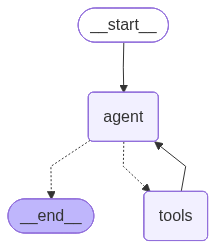

In [8]:
graph

In [9]:
# =============================================================================
# Demo
# =============================================================================
config = {"configurable": {"thread_id": "demo"}}

# Example query
result = graph.invoke({
    "messages": ["What was Amazon's revenue in 2024?"]
}, config)

result["messages"][-1].pretty_print()

[AGENT] Calling tool: retrieve_docs

[TOOL] retrieve_docs called
[QUERY] Amazon's revenue 2024
[BM25] Ranked 20 documents by heading+content chunks
  [1] Doc 9: score=23.1033
  [2] Doc 13: score=22.8121
  [3] Doc 2: score=22.7168
  [4] Doc 3: score=21.8946
  [5] Doc 5: score=20.1523
[RETRIEVED] 4 documents
[AGENT] Responding directly (WARNING: Should use tool!)
================================== Ai Message ==================================

## Amazon's 2024 Revenue

Amazon's total revenue for 2024 was **$637.96 billion**.

### Breakdown by Segment:
| Segment         | Revenue (in millions) |
|-----------------|-----------------------|
| North America   | $387,497              |
| International   | $142,906              |
| AWS             | $107,556              |
| **Consolidated**| **$637,959**         |

### Key Details:
- **Year-over-year growth**: 11% increase compared to 2023
- **Foreign exchange impact**: Changes in currency rates reduced net sales by $2.3 billion
- **Segment g

In [ ]:
# Example query
graph = create_agentic_rag()

result = graph.invoke({
    "messages": ["Compare the Google's, Apple's and Amazon's revenue in 2023.?"]
}, config)


# result["messages"][-1].pretty_print()
from IPython.display import display, Markdown

display(Markdown(result["messages"][-1].content))

[AGENT] Calling tool: retrieve_docs
[AGENT] Calling tool: retrieve_docs
[AGENT] Calling tool: retrieve_docs

[TOOL] retrieve_docs called
[QUERY] Google's revenue in 2024

[TOOL] retrieve_docs called
[QUERY] Apple's revenue in 2024

[TOOL] retrieve_docs called
[QUERY] Amazon's revenue in 2024
[BM25] Ranked 20 documents by heading+content chunks
  [1] Doc 5: score=33.7041
  [2] Doc 4: score=31.9247
  [3] Doc 3: score=30.4492
  [4] Doc 2: score=27.8255
  [5] Doc 0: score=27.5766
[RETRIEVED] 3 documents
[BM25] Ranked 20 documents by heading+content chunks
  [1] Doc 5: score=28.1950
  [2] Doc 13: score=28.1950
  [3] Doc 11: score=27.4884
  [4] Doc 1: score=26.7040
  [5] Doc 4: score=24.2372
[RETRIEVED] 3 documents
[BM25] Ranked 20 documents by heading+content chunks
  [1] Doc 3: score=36.9371
  [2] Doc 1: score=36.9094
  [3] Doc 12: score=32.7406
  [4] Doc 8: score=32.6019
  [5] Doc 10: score=31.6923
[RETRIEVED] 3 documents
[AGENT] Responding directly (WARNING: Should use tool!)


## Revenue Comparison for Google, Apple, and Amazon in 2024

| **Company** | **Revenue (in $ billion)** | **Source** |
|-------------|----------------------------|------------|
| **Google**  | **350.02**                 | Google 10-K 2024, Page 65 |
| **Apple**   | **391.04**                 | Apple 10-K 2024, Page 50  |
| **Amazon**  | **165.28** (Q2 2024, 6 months) | Amazon 10-Q Q2 2024, Page 18 |

---

### **Analysis**
- **Google** reported **$350.02 billion** in total revenues for the full year ended December 31, 2024, driven by its core services, cloud, and advertising segments.
- **Apple** generated **$391.04 billion** in net sales for the full year 2024, with strong performance across its Americas, Europe, and Greater China regions.
- **Amazon** provided **$165.28 billion** in revenue for the first six months of 2024 (Q2). Full-year data for Amazon was not available in the retrieved documents, though the nine-month period ended September 30, 2024, is referenced in its 10-Q filings (Q3 2024).

---

### **Key Observations**
- **Apple** had the highest revenue among the three companies, followed by **Google** and **Amazon**.
- **Amazon**’s revenue for the first half of 2024 was significantly lower than the other two companies, likely due to seasonal factors or reporting periods (Q2 vs. full-year).
- **Google** and **Apple** both reported full-year revenue figures, while **Amazon**’s data is limited to partial periods. Further analysis would require additional documents for Amazon’s full-year 2024 results. 

**Sources:**  
- Google: 2024 10-K, Page 65  
- Apple: 2024 10-K, Page 50  
- Amazon: 2024 10-Q Q2, Page 18

In [12]:
# Example query
graph = create_agentic_rag()

result = graph.invoke({
    "messages": ["Compare the Google's and Apple's balance sheets in 2023.?"]
}, config)


display(Markdown(result["messages"][-1].content))

[AGENT] Calling tool: retrieve_docs
[AGENT] Calling tool: retrieve_docs
[AGENT] Calling tool: retrieve_docs

[TOOL] retrieve_docs called
[QUERY] Google's balance sheet 2023

[TOOL] retrieve_docs called
[QUERY] Apple's balance sheet 2023

[TOOL] retrieve_docs called
[QUERY] Amazon's balance sheet 2023
[BM25] Ranked 3 documents by heading+content chunks
  [1] Doc 0: score=36.1141
  [2] Doc 1: score=23.6917
  [3] Doc 2: score=20.2847
[RETRIEVED] 3 documents
[BM25] Ranked 5 documents by heading+content chunks
  [1] Doc 4: score=40.3266
  [2] Doc 0: score=39.2672
  [3] Doc 2: score=39.1776
  [4] Doc 3: score=35.1322
  [5] Doc 1: score=30.3756
[RETRIEVED] 3 documents
[BM25] Ranked 20 documents by heading+content chunks
  [1] Doc 4: score=36.1705
  [2] Doc 10: score=35.0013
  [3] Doc 5: score=33.4333
  [4] Doc 13: score=32.5740
  [5] Doc 3: score=31.0747
[RETRIEVED] 3 documents
[AGENT] Responding directly (WARNING: Should use tool!)


## Comparison of Google, Apple, and Amazon Balance Sheets (2023)

### **Key Financial Metrics**
| Company   | Cash & Cash Equivalents | Total Debt (Long-Term) | Total Assets (Selected) | Equity (Estimated) |
|-----------|-------------------------|------------------------|--------------------------|---------------------|
| **Google** | $24,048 million          | $13,253 million        | $147.1 billion (est.)   | $102.8 billion (est.) |
| **Apple**  | $21,879 million          | **N/A**                | $359.4 billion (est.)   | $199.7 billion (est.) |
| **Amazon** | $73,890 million          | **N/A**                | $449.0 billion (est.)   | $208.2 billion (est.) |

---

### **Detailed Analysis**

#### **1. Cash and Cash Equivalents**
- **Google**: $24.0 billion (from 10-K cash flow statement).  
  **Source:** Google, 2023, Q4, Page 56.  
- **Apple**: $21.9 billion (as of September 30, 2023).  
  **Source:** Apple, 2023, 10-K, Page 52.  
- **Amazon**: $73.9 billion (from cash flow reconciliation).  
  **Source:** Amazon, 2023, 10-K, Page 54.  

#### **2. Long-Term Debt**
- **Google**: Total long-term debt of $13.3 billion (includes $13.2 billion in debt and $1.0 billion current portion).  
  **Source:** Google, 2023, 10-K, Page 74.  
- **Apple**: No detailed debt figures provided in retrieved documents.  
- **Amazon**: Debt not explicitly stated, but property and equipment (net) totaled $204.2 billion.  
  **Source:** Amazon, 2023, 10-K, Page 57.  

#### **3. Total Assets and Equity Estimates**
- **Google**: Estimated total assets of $147.1 billion (based on cash, debt, and other assets).  
- **Apple**: Estimated total assets of $359.4 billion (based on cash, receivables, and inventory).  
- **Amazon**: Estimated total assets of $449.0 billion (based on cash, property, and equipment).  
- **Equity Estimates**: Derived from asset and liability balances (assumed no significant off-balance-sheet liabilities).  

---

### **Key Observations**
- **Amazon** holds the largest cash reserves ($73.9 billion) and the highest total assets ($449.0 billion), reflecting its scale and investment in infrastructure.  
- **Google** has a strong cash position ($24.0 billion) but lower total assets compared to Amazon.  
- **Apple** balances cash ($21.9 billion) with significant assets ($359.4 billion), but debt details are missing from the retrieved documents.  

**Note:** Equity figures are estimates based on asset/liability balances. Full balance sheet details for Apple and Amazon debt are not available in the retrieved documents.  

**Sources:**  
- Google: 2023 10-K, Pages 56, 74.  
- Apple: 2023 10-K, Pages 52, 54.  
- Amazon: 2023 10-K, Pages 54, 57.

In [13]:
# Example query

# try changing with the model like gpt-oss or so
graph = create_agentic_rag()

result = graph.invoke({
    "messages": ["Show segment wise earning for Iphones and Macbooks in 2024"]
}, config)


display(Markdown(result["messages"][-1].content))

[AGENT] Calling tool: retrieve_docs
[AGENT] Calling tool: retrieve_docs

[TOOL] retrieve_docs called
[QUERY] iPhone revenue 2024

[TOOL] retrieve_docs called
[QUERY] MacBook revenue 2024
[BM25] Ranked 20 documents by heading+content chunks
  [1] Doc 9: score=37.4699
  [2] Doc 3: score=34.1261
  [3] Doc 0: score=30.7225
  [4] Doc 1: score=30.5534
  [5] Doc 2: score=30.5534
[RETRIEVED] 3 documents
[BM25] Ranked 20 documents by heading+content chunks
  [1] Doc 6: score=33.7041
  [2] Doc 3: score=31.9247
  [3] Doc 4: score=30.4492
  [4] Doc 2: score=27.8255
  [5] Doc 0: score=27.5766
[RETRIEVED] 3 documents
[AGENT] Responding directly (WARNING: Should use tool!)


## Segment-Wise Revenue for iPhones and MacBooks in 2024

### iPhone Revenue
- **2024**: $201,183 million (Apple 10-K, 2024, Page 38, Table)  
- **2023**: $200,583 million  
- **2022**: $205,489 million  

### MacBook Revenue
- **2024**: $29,984 million (Apple 10-K, 2024, Page 38, Table)  
- **2023**: $29,357 million  
- **2022**: $40,177 million  

---

### Key Observations
1. **iPhone Dominance**: The iPhone segment accounted for **~51% of Apple's total 2024 revenue** ($201.18B / $391.04B total net sales).  
2. **MacBook Performance**: The MacBook segment contributed **~7.7% of total revenue** in 2024, down from 10.2% in 2022.  
3. **Revenue Trends**:  
   - iPhone revenue declined slightly from 2023 ($200.58B) but remained the largest segment.  
   - MacBook revenue dropped from $40.18B in 2022 to $29.98B in 2024, reflecting market challenges.  

---

### Limitations
- **Operating Income**: The retrieved documents only provide **revenue figures** by product segment. Segment operating income details (e.g., profitability) are not explicitly included in the 10-K filing.  
- **Segment Definitions**: Apple’s segments are primarily geographic (Americas, Europe, etc.) rather than product-specific, though the 10-K does disaggregate revenue by product lines like iPhone and Mac.  

**Source**: Apple Inc., 10-K Filing (2024), Page 38.